# Лабораторная работа №2: "Вулканическая баллистика"

## Библиотеки

In [1]:
from numpy.random import Generator, PCG64
from scipy.optimize import root_scalar, brentq, fsolve, minimize_scalar
from typing import Dict, List
from scipy.optimize import root_scalar
import matplotlib.pyplot as plt
import numpy as np
import simpy as sim
import pandas as pd
import matplotlib.pyplot as plt
import csv

In [2]:
g_vec = np.array([0, 0, -9.81])

## Класс бомбы

In [3]:
class Bomb:
    def __init__(self,
                 t_erup: float,
                 r0: np.ndarray,
                 v0: np.ndarray,
                 mass: float,
                 radius: float):
        self.t_erup = t_erup
        self.r = r0
        self.v = v0
        self.m = mass
        self.R = radius
        self.is_coll = False
        # TODO: + ваши поля, которые посчитаете нужным использовать
    
    def calc_r(self, t: float):
        """Рассчитать радиус-вектор в момент времени `t`."""
        return 0.5*g_vec*(t-self.t_erup)**2 + self.v*(t-self.t_erup) + self.r
    
    def calc_v(self, t: float):
        """Рассчитать вектор скорости в момент времени `t`."""
        return self.v + g_vec*(t-self.t_erup)
    
    def is_collided(self):
        """Столкивался ли камень."""
        pass
    
    def xy_fall(self):
        """Координаты падения."""
        t = when_ground(self, is_pr=True)
        return self.calc_r(t)[:-1]

## Модель

Глобальные списки летящих камней и камней на земле, а также словарь (хэш-таблица) процессов каждого экземпляра бомбы:

In [4]:
flyings, fallens = [], []
processes: Dict[Bomb, List[sim.Process]] = {}

Функция формирования генератора чисел:

In [5]:
def get_rand_state(seed: int):
    return Generator(PCG64(seed))

Процесс выброса камней при извержении. Всего таких процессов при моделировании `n_erups`:

In [6]:
def eruption(env: sim.Environment, dt: float, n: int, rs: Generator, allow_colision):
    """Процесс (в терминах `SimPy`) i-го выброса камней.
    
    env :
        Объект среды `SimPy`,
        отвечающий за управление и обработку событий.
    dt :
        Задержка начала процесса.
    n :
        Число выбрасываемых камней.
    rs :
        Генератор чисел.
    """
    yield env.timeout(dt)   # Ожидание события ERUPTION
    # TODO: action при наступлении события ERUPTION
    bs = gen_bombs(env, n, rs)
    for b in bs:
        time = when_ground(b)
        processes[b] = []
        processes[b].append(env.process(ground(env, time, b)))
        if allow_colision:
            for bb in flyings:
                if bb is b:
                    continue
                t_col = when_collision(b, bb)
                if t_col is np.inf:
                    continue
                processes[b].append(env.process(collision(env, t_col, b, bb)))
        flyings.append(b)

Функция генерации камней:

In [7]:
def gen_bombs(env: sim.Environment, n: int, rs: Generator):
    """Сгенерировать n бомб (камней).

    env :
        Объект среды `SimPy`,
        отвечающий за управление и обработку событий.
    n :
        Число выбрасываемых камней.
    rs :
        Генератор чисел.
    """
    R_c = 100
    D_c = 25
    H = 250
    mu_s, sigma_s = 15, 4
    mu_teta, sigma_teta = 80/180*np.pi, 20/180*np.pi
    R_min, R_max = 1, 5
    rho = 5800
    r = rs.uniform(low=0, high=R_c, size=n)
    z = rs.uniform(low=H-D_c, high=H, size=n)
    fi = rs.uniform(low=0, high=2*np.pi, size=n)
    teta = rs.normal(loc=mu_teta, scale=sigma_teta, size=n)
    vel = rs.normal(loc=mu_s, scale=sigma_s, size=n)
    R = rs.uniform(low=R_min, high=R_max, size=n)
    bombs = []
    for i in range(n):
        teta[i] = max(0, teta[i])
        vel[i] = max(2 ,vel[i])
        b = Bomb(
                t_erup=env.now,
                r0=np.array([r[i]*np.cos(fi[i]), r[i]*np.sin(fi[i]), z[i]]),
                v0=np.array([vel[i]*np.cos(teta[i])*np.cos(fi[i]), vel[i]*np.cos(teta[i])*np.sin(fi[i]), vel[i]*np.sin(teta[i])]),
                mass=4/3*np.pi*R[i]**3*rho,
                radius=R[i])
        bombs.append(b)
    return bombs

Функция-**процесс**, отвечающая действию при событии `GROUND`:

In [8]:
def ground(env: sim.Environment, dt: float, b: Bomb):
    """Процесс (в терминах `SimPy`), происходящий при наступлении
    события `GROUND`.
    
    env :
        Объект среды `SimPy`,
        отвечающий за управление и обработку событий.
    dt :
        Задержка начала процесса.
    b :
        Бомба (камень).
    """
    try:
        yield env.timeout(dt)
        # TODO:
        clear_queue(b)
        if b in flyings:
            flyings.remove(b)
        fallens.append(b)
    except sim.Interrupt:
        return

Функция-**процесс**, описывающая действие при событии `COLLISION`:

In [91]:
def collision(env: sim.Environment, dt: float, b1: Bomb, b2: Bomb):
    """Процесс (в терминах `SimPy`), происходящий при наступлении
    события `COLLISION`.
    
    env :
        Объект среды `SimPy`,
        отвечающий за управление и обработку событий.
    dt :
        Задержка начала процесса.
    b1 и b2 :
        Бомбы.
    """
    try:
        yield env.timeout(dt)
        # TODO: ...
        clear_queue(b1)
        clear_queue(b2)
        v1, v2 = calc_collision(env.now, b1, b2)
        
        b1.r, b2.r = b1.calc_r(env.now), b2.calc_r(env.now)
        b1.v, b2.v = v1, v2
        b1.t_erup, b2.t_erup = env.now, env.now
        b1.is_coll, b2.is_coll = True, True
        for b in [b1, b2]:
            try:
                time = when_ground(b)
            except ValueError as err:
                return
            processes[b].append(env.process(ground(env, time, b)))
            for bb in flyings:
                if bb is b:
                    continue
                t_col = when_collision(b, bb)
                if t_col is np.inf:
                    continue
                processes[b].append(env.process(collision(env, t_col, b, bb)))
    except sim.Interrupt:
        return

Функция очистки очереди событий, связанных с бомбой `b`:

In [10]:
def clear_queue(b: Bomb):
    for proc in processes[b]:
        try:
            proc.interrupt()
        except RuntimeError:
            continue

Функция расчёта времени падения камня на землю ($z=0$):

In [97]:
def when_ground(b: Bomb, is_pr = False):
    r_z = b.r[-1]
    v_z = b.v[-1]
    g_z = g_vec[-1]
    time = (-v_z - np.sqrt(v_z**2 - 2*g_z*r_z))/g_z
    #if time < 0:
        #print(time, f"r={r_z}, v={v_z}, g={g_z}")
    #   raise ValueError("time < 0")
    return time+b.t_erup

Функция расчёта скоростей бомб `b1` и `b2` после их столкновения в момент времени `t`:

In [96]:
def calc_collision(t: float, b1: Bomb, b2: Bomb, c = 0.8):
    v_1 = b1.calc_v(t)
    v_2 = b2.calc_v(t)
    norm = (b1.calc_r(t) - b2.calc_r(t))/np.linalg.norm(b1.calc_r(t) - b2.calc_r(t))
    v_c = -(v_1 - v_2)@norm
    v_s = -v_c
    d_v_s = -c*v_s - v_s
    p = b1.m*b2.m/(b1.m+b2.m)*d_v_s*norm
    return v_1 + p/b1.m, v_2 - p/b2.m

Функция расчёта момента времени столкновения камня `b1` с камнем `b2`:

In [94]:
def when_collision(b1: Bomb, b2: Bomb):

    def dist(t):
        dist = np.linalg.norm(b1.calc_r(t) - b2.calc_r(t))
        if dist <= b1.R + b2.R:
            return 0
        return dist
    
    time_l = max(b1.t_erup, b2.t_erup)
    try:
        time_r = min(when_ground(b1), when_ground(b2))
    except ValueError:
        return np.inf
    if time_l >= time_r:
        return np.inf
    result = minimize_scalar(dist, method='bounded', bounds=(time_l, time_r))
    if not result.success:
        return np.inf
    if result.fun <= b1.R + b2.R:
        return result.x
    return np.inf

Функция-**процесс** моделирования извержения:

In [14]:
def simulation(env: sim.Environment,
               n_erups: int,
               rs: Generator,
               allowed_collisions):
    """Процесс (в терминах `SimPy`) моделирования.
    
    env :
        Объект среды `SimPy`,
        отвечающий за управление и обработку событий.
    n_erups :
        Количество извержений.
    rs :
        Генератор чисел.
    allowed_collisions :
        Столкновения возможны (`True`) или нет (`False`).
    """
    betta = 120
    n_bombs = 100
    for i in range(n_erups):
        time = rs.exponential(scale=betta)
        yield env.process(eruption(env, time, n_bombs, rs, allowed_collisions))
        print(i)

Функция **запуска** моделирования извержения (с или без учёта столкновения камней):

In [15]:
def simulate(n_erups: int,
             allowed_collisions,
             seed: int = None):
    """Запустить моделирование извержения.
    
    n_erups:
        Количество извержений.
    allowed_collisions :
        Столкновения возможны (`True`) или нет (`False`).
    seed:
        Затравка для генератора чисел.
    """
    rs = get_rand_state(seed)
    env = sim.Environment()
    pc = env.process(simulation(env, n_erups, rs, allowed_collisions))
    env.run()

Основная функция компьютерной модели:

In [16]:
def main(n_erups: int, allowed_collision=False):
    """Главная функция - точка входа в программу.
    
    n_erups :
        Количество извержений.
    """
    # TODO: ...
    simulate(n_erups, allowed_collision, seed=1077)
    # TODO: ...
    return 0

## Моделирование

In [98]:
flyings, fallens = [], []
processes: Dict[Bomb, List[sim.Process]] = {}

In [99]:
n_erups, allowed_collision = 15, True   # Назначайте любое значение, но не менее 12
main(n_erups, allowed_collision)

0
1


C:\Users\Maksim\AppData\Local\Temp\ipykernel_7068\3462850133.py:5: RuntimeWarning: invalid value encountered in sqrt
  time = (-v_z - np.sqrt(v_z**2 - 2*g_z*r_z))/g_z


Interrupt: Interrupt(None)

In [75]:
points = [{'x': b.xy_fall()[0], 'y': b.xy_fall()[1], 'collision':b.is_coll } for b in fallens]

In [76]:
tabel_points = pd.DataFrame(points)

In [77]:
tabel_points.to_csv("data/collision_zhen.csv") if allowed_collision else tabel_points.to_csv("data/not_collision_zhen.csv")

## Визуализация

Универсальная функция визуализации точек падения камней:

In [78]:
df_col = pd.read_csv("data/collision_zhen.csv")
df_col_col = df_col.loc[df_col["collision"] == True]
df_col_not_col = df_col.loc[df_col["collision"] != True]
df_not_col = pd.read_csv("data/not_collision_zhen.csv")

In [80]:
df_col_col

,Unnamed: 0,x,y,collision


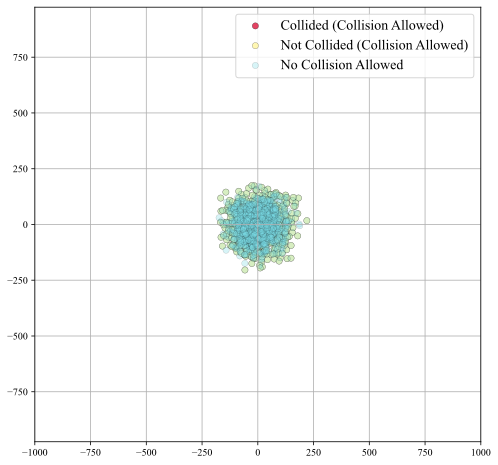

In [79]:
%matplotlib inline 
%config InlineBackend.figure_format = 'svg' 
rc = {"font.family" : "serif", 
      "mathtext.fontset" : "stix"}
plt.rcParams.update(rc)
plt.rcParams["font.serif"] = ["Times New Roman"] + plt.rcParams["font.serif"]
fs = 14
frameLength = 1000
fig = plt.figure(figsize=(8,8), dpi=200)
plt.grid()
plt.scatter(df_col_col['x'], df_col_col['y'], c='#dc143c', s=40, alpha=0.8, label='Collided (Collision Allowed)',  edgecolor='black', linewidth=0.3)
plt.scatter(df_col_not_col['x'], df_col_not_col['y'], c='#FFF17F', s=40, alpha=0.6, label='Not Collided (Collision Allowed)',  edgecolor='black', linewidth=0.3)
plt.scatter(df_not_col['x'], df_not_col['y'], c='#78DBE2', edgecolor='black', linewidth=0.3, s=40, alpha=0.3, marker='o', label='No Collision Allowed')
plt.axis('equal')
plt.xlim(-frameLength, frameLength)
plt.ylim(-frameLength, frameLength)
plt.legend(fontsize=14, loc='upper right')
plt.show()

## Рекомендации

* Используйте функции [`save`](https://numpy.org/doc/stable/reference/generated/numpy.save.html) и/или [`savez`](https://numpy.org/doc/stable/reference/generated/numpy.savez.html) библиотеки `NumPy` для сохранения точек падения. Вам не нужно будет хранить все полученные данные в оперативной памяти. После моделирования вы сможете читать данные в другой части кода, отделённой от той его части, которая отвечает за моделирование.
* Решить уравнение встречи бомб можете численным методом [`root_scalar`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.root_scalar.html) из пакета `SciPy`.
* Используйте библиотеку дискретно-событийного моделирования [`SimPy`](https://simpy.readthedocs.io/en/latest/), чтобы не изобретать велосипед. Либо реализуйте программу согласно псевдокоду с лекции по теме дискретно-событийного моделирования.

In [57]:
a = np.array([0, 2, 3])

In [58]:
b = np.array([6, 7, 8])

In [59]:
a@b

38

In [61]:
np.sum(a*b)

38